# Ideal Imagery Product Generation

_A guide to setting up a synthetic imagery product and generating it_

In [14]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as tf

base_dir = os.path.dirname(os.getcwd())
sys.path.append(base_dir)

from src import Digit, Product, TSDataset, TimeSerie, Blob
from src import transforms
from src.utils import list_collate

SEED = 73

> For the purpose of this demonstration, we'll create an ignored `sandbox` directory

In [7]:
! mkdir sandbox

mkdir: sandbox: File exists


## Setup Imagery Product

A Product is conceived as a dictionnary of `Digit`, endowed with :
- A background image `bg`
- Spatial and temporal dimensions characteristics (`size`, `nbands`, `horizon`)
- A stochastic augmentation operator for digits `blob_transform`
- A randomized patching strategy for digits `mode` along with a random distribution to use `rdm_dist` (see docstring)

Each digit is built as an image from the MNIST dataset, endowed with :

- An optional geometric augmentation callable that is specific to the digit
- A label
- A time serie from class `TimeSerie` used as an update process for the digit pixels

#### Load MNIST and TS Datasets for Digits instanciation

In [2]:
# MNIST
batch_size = 42
data_path = "../data/mnist"

mnist = MNIST(root=data_path, train=True)
dataloader = DataLoader(dataset=mnist,
                        batch_size=batch_size,
                        collate_fn=list_collate)

mnist

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../../../../Documents/Programming/torchsession/test/
    Split: Train

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   dim_0   128 non-null    object
 1   dim_1   128 non-null    object
 2   dim_2   128 non-null    object
dtypes: object(3)
memory usage: 3.1+ KB



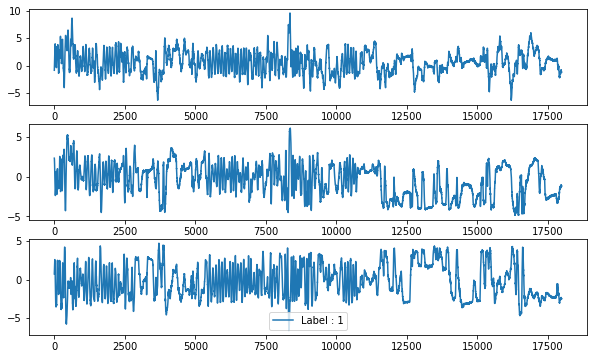

In [3]:
# Time Serie
root = '../data/ts/Multivariate_ts/EigenWorms/EigenWorms_TRAIN.ts'
ts_dataset = TSDataset(root=root)

# Hardset the number of dimension to 3 to allow RGB visualization of product
ts_dataset._data = ts_dataset._data[['dim_0', 'dim_1', 'dim_2']]

print(ts_dataset)
ts_dataset.plot(0)

#### Define product transform for its digits

`Blob` and `Digit` class directly inherit from `PIL.Image.Image`, we define an stochastic augmentation operator compatible with `PIL` essentially based on `torchvision.transform`

In [17]:
digit_transform = tf.Compose([tf.RandomAffine(degrees=(-90, 90),
                                              scale=(0.5, 1),
                                              shear=(-1, 1)),
                              tf.RandomChoice([tf.RandomHorizontalFlip(0.5),
                                               tf.RandomVerticalFlip(0.5)]),
                              tf.RandomPerspective(),
                              transforms.RandomScale(scale=(5, 15))])

> _Transform visualization on dummy example_

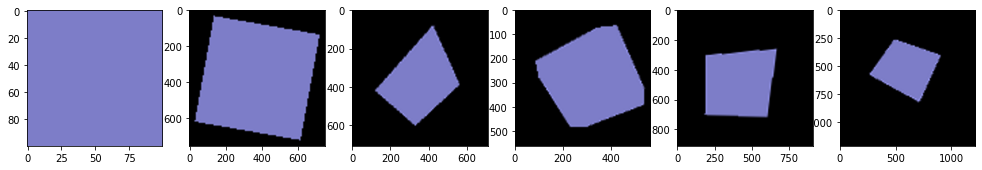

In [19]:
dummy_img = Image.new(mode='RGB', size=(100, 100), color=(125, 125, 200))
fig, ax = plt.subplots(1, 6, figsize=(17, 10))
ax[0].imshow(dummy_img)
for i in range(1, 6):
    ax[i].imshow(digit_transform(dummy_img))

#### Instantiate product


In [36]:
product_kwargs = {'size': (2048, 2048),
                  'nbands': 3,
                  'horizon': 32,
                  'grid_size': (256, 256),
                  'color': 0,
                  'mode': 'grid',
                  'seed': SEED,
                  'rdm_dist': lambda *args, **kwargs: 2 * np.random.randn(*args, **kwargs),
                  'blob_transform': digit_transform}

product = Product(**product_kwargs)
product

{}

As you can see, at first the product is nothing else than an enhanced empty dictionnary

#### Register batch of digits to product
should yield `StopIteration` exception if `batch_size` > #availableGridSlots

In [38]:
digits, _ = iter(dataloader).next()
seeds = range(dataloader.batch_size)

In [39]:
for img, seed in zip(digits, seeds):
    # Draw random time serie from dataset
    ts, label = ts_dataset.choice()
    # Create time serie instance with same or greater horizon 
    time_serie = TimeSerie(ts, label, horizon=product.horizon, seed=seed)
    # Encapsulate at digit level
    d = Digit(img, label=label, time_serie=time_serie)
    product.random_register(d, seed=seed)

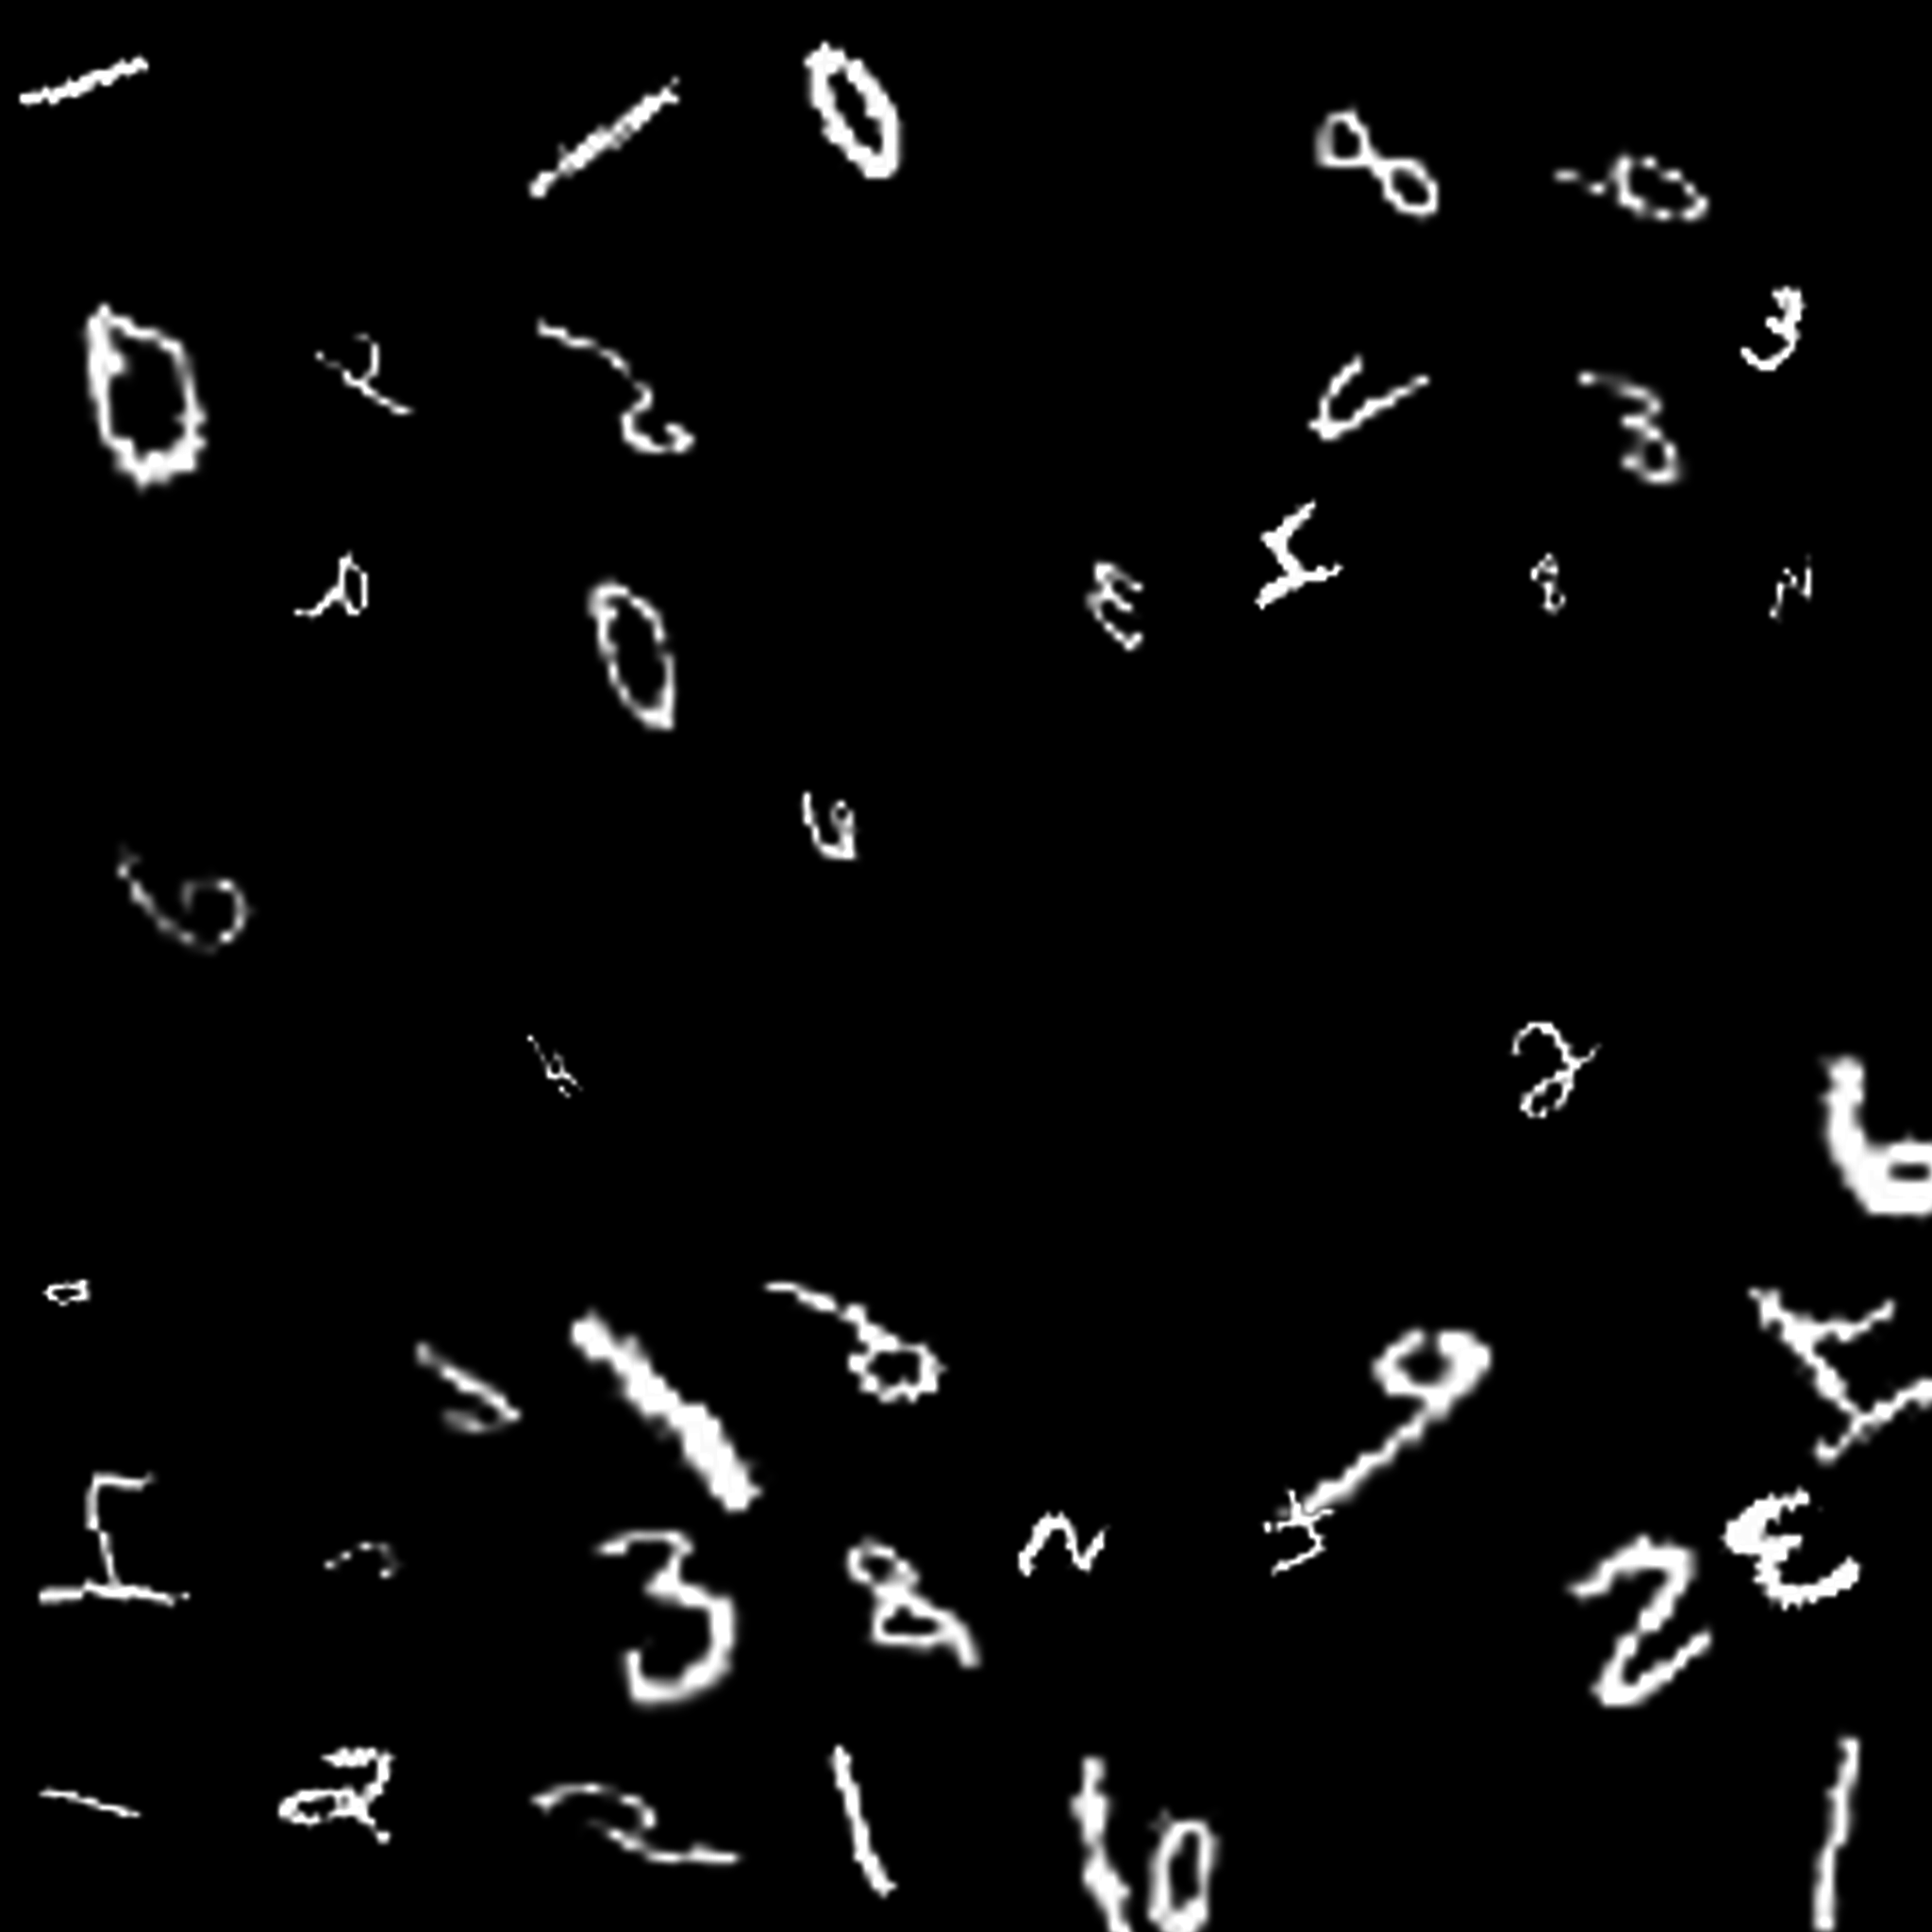

In [44]:
# Generate quick grayscale view of product
product.view()

---

## Generate Product

`Product` then allows to run generation on the fly, dumping results into a directory structured as :

```
directory_name/
├── data/          # where images/arrays are going to be dumped
└── index.json     # product description json file
```

The index files contains a `features` subdict describing product main characteristics as well as a `files` subdict keeping track of dumped files names and ordering

#### To generate as  jpg images

_Only works with 3-bands products_ 

In [47]:
# Generate view for each time step and save them somewhere
# From command line, you should see a progress bar while generating
output_dir = "sandbox/latent_product_jpg"
product.generate(output_dir=output_dir, astype='jpg')

/Users/dieze/Desktop/mount_directory/ds-virtual-remote-sensing-toy/src/utils/IOHandler.py:21: UserWarning: directory ../../../latent_product_npy already exists
  warnings.warn(f"directory {dirpath} already exists")
/Users/dieze/Desktop/mount_directory/ds-virtual-remote-sensing-toy/src/utils/IOHandler.py:21: UserWarning: directory ../../../latent_product_npy/data/ already exists
  warnings.warn(f"directory {dirpath} already exists")


#### To generate as numpy arrays

_Works with any number of bands_

In [ ]:
# Generate view for each time step and save them somewhere
# From command line, you should see a progress bar while generating
output_dir = "sandbox/latent_product_npy"
product.generate(output_dir=output_dir, astype='npy')

---